# BC4 

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

May 2022

https://github.com/fpontejos/bc4


## Initial Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
import itertools
import collections
import ta

warnings.filterwarnings('ignore')



In [2]:
from matplotlib.colors import LinearSegmentedColormap


In [3]:
from functools import reduce

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [5]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()


### Variables

In [6]:
COLORS = ['#2ec4b6', '#1e9fb4', '#0f7ab2', '#285892', '#49306b', '#7a3161', '#a13258', '#c63351', '#ea3449']

CAT_COLORS = ['#2EC4B6', '#0E79B2', '#49306B', '#9A325A', '#EA3449']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#0e79b2', '#4b9ac3', '#84b8d4', '#bcd6e4', '#f4f4f4', '#c6c0d0', '#9b8eac', '#715e8b', '#49306b']

DIV_COL_HALF = ['#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
DIVHALF_PALETTE = sns.color_palette(DIV_COL_HALF)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
DIV_H_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COL_HALF)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = '../imgs/'
DATA_IN_PATH = '../../source/data/'
DATA_OUT_PATH = '../../data_out/'


In [7]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight', transparent=True)
        


### Styles

In [8]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

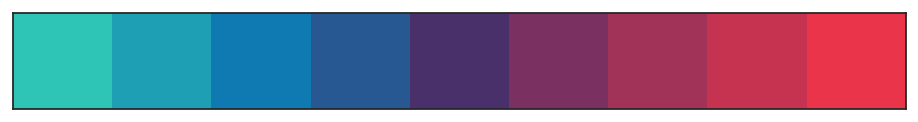

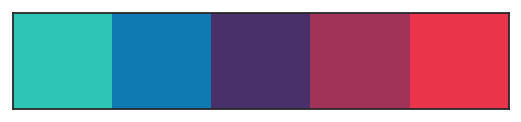

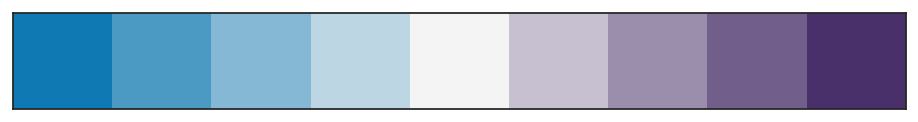

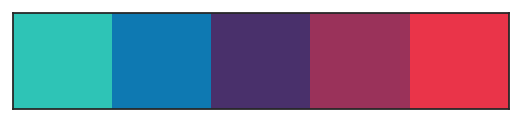

In [9]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Load Data

In [10]:
df_adjclose = pd.read_csv(DATA_IN_PATH + "adj_close.csv")
#df_adjclose.head(3)

In [11]:
df_close = pd.read_csv(DATA_IN_PATH + "close.csv")
#df_close.head(3)

In [12]:
df_high = pd.read_csv(DATA_IN_PATH + "high.csv")
#df_high.head(3)

In [13]:
df_low = pd.read_csv(DATA_IN_PATH + "low.csv")
#df_low.head(3)

In [14]:
df_open = pd.read_csv(DATA_IN_PATH + "open.csv")
#df_open.head(3)

In [15]:
df_vol = pd.read_csv(DATA_IN_PATH + "volume.csv")
#df_vol.head(3)

In [16]:
df_list = [df_adjclose,df_close,df_high,df_low]

In [17]:
def assemble_coin_df(coin_i):
    df_data = df_close[['Date',coin_i]].rename(columns={coin_i:'close'})\
            .merge(df_high[['Date',coin_i]].rename(columns={coin_i:'high'}), left_on='Date', right_on='Date')\
            .merge(df_low[['Date',coin_i]].rename(columns={coin_i:'low'}), left_on='Date', right_on='Date')\
            .merge(df_open[['Date',coin_i]].rename(columns={coin_i:'open'}), left_on='Date', right_on='Date')\
            .merge(df_vol[['Date',coin_i]].rename(columns={coin_i:'volume'}), left_on='Date', right_on='Date')
    return df_data


df_ada   = assemble_coin_df('ADA-USD')
df_atom  = assemble_coin_df('ATOM-USD')
df_avax  = assemble_coin_df('AVAX-USD')
df_axs   = assemble_coin_df('AXS-USD')
df_btc   = assemble_coin_df('BTC-USD')
df_eth   = assemble_coin_df('ETH-USD')
df_link  = assemble_coin_df('LINK-USD')
df_luna1 = assemble_coin_df('LUNA1-USD')
df_matic = assemble_coin_df('MATIC-USD')
df_sol   = assemble_coin_df('SOL-USD')



In [18]:
## There are two days with prices, then a long period without. 
## Remove these two days.

df_avax.loc[df_avax['Date']=='2020-07-13',['close', 'high', 'low', 'open', 'volume']] = np.nan
df_avax.loc[df_avax['Date']=='2020-07-14',['close', 'high', 'low', 'open', 'volume']] = np.nan
df_avax.loc[df_avax['Date']>='2020-07-13',['close', 'high', 'low', 'open', 'volume']]


,close,high,low,open,volume
1174,NaN,NaN,NaN,NaN,NaN
1175,NaN,NaN,NaN,NaN,NaN
1176,NaN,NaN,NaN,NaN,NaN
1177,NaN,NaN,NaN,NaN,NaN
1178,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1821,75.080742,80.008301,74.412254,78.268646,569385150.0
1822,74.122963,77.152420,73.490158,75.084648,532238762.0
1823,72.920013,74.369293,72.632584,74.127480,360787956.0
1824,71.603035,73.437004,71.342026,72.892731,320340266.0


In [19]:
df_avax.columns

Index(['Date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')

In [20]:
df_coins_list = [df_ada, df_atom, df_avax, df_axs, df_btc, df_eth, df_link, df_luna1, df_matic, df_sol]
df_coins_suff = ['ada', 'atom', 'avax', 'axs', 'btc', 'eth', 'link', 'luna1', 'matic', 'sol']

In [21]:
for i in range(len(df_coins_suff)):
    di = df_coins_list[i]
    df_coins_list[i] = df_coins_list[i].add_prefix(df_coins_suff[i]+'_')
    date_col = df_coins_suff[i]+'_Date'
    df_coins_list[i].rename(columns={date_col: 'Date'}, inplace=True)
    

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='left'), df_coins_list)

In [22]:
df_merged['Date'].min()

'2017-04-26'

In [23]:
df_merged['Date'].max()

'2022-04-25'

In [24]:
df_merged

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume,atom_close,atom_high,atom_low,atom_open,...,matic_close,matic_high,matic_low,matic_open,matic_volume,sol_close,sol_high,sol_low,sol_open,sol_volume
0,2017-04-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-04-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2022-04-21,0.910474,0.969453,0.896912,0.937272,8.711113e+08,23.305845,24.913876,23.070230,24.290905,...,1.379862,1.465750,1.368370,1.417712,6.526199e+08,101.776138,109.765327,100.767151,105.497673,1.838572e+09
1822,2022-04-22,0.907154,0.923741,0.893973,0.910335,7.257889e+08,23.089931,23.845695,22.957436,23.305815,...,1.399139,1.496747,1.374800,1.379697,1.281223e+09,100.612053,103.498146,99.579430,101.757423,1.274794e+09
1823,2022-04-23,0.888503,0.910614,0.884660,0.907185,4.479977e+08,23.271534,23.452826,22.864717,23.089521,...,1.365971,1.406944,1.350815,1.399106,5.494467e+08,100.744438,102.771233,98.781570,100.619781,8.232525e+08
1824,2022-04-24,0.886350,0.897855,0.881857,0.888279,4.876295e+08,22.330360,23.259838,22.315559,23.259838,...,1.344245,1.373304,1.335365,1.365753,4.209603e+08,99.235794,102.216682,99.008514,100.727188,8.182660e+08


## Understanding the Data

In [25]:
df_coins_list[0]

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume
0,2017-04-26,NaN,NaN,NaN,NaN,NaN
1,2017-04-27,NaN,NaN,NaN,NaN,NaN
2,2017-04-28,NaN,NaN,NaN,NaN,NaN
3,2017-04-29,NaN,NaN,NaN,NaN,NaN
4,2017-04-30,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1821,2022-04-21,0.910474,0.969453,0.896912,0.937272,8.711113e+08
1822,2022-04-22,0.907154,0.923741,0.893973,0.910335,7.257889e+08
1823,2022-04-23,0.888503,0.910614,0.884660,0.907185,4.479977e+08
1824,2022-04-24,0.886350,0.897855,0.881857,0.888279,4.876295e+08


In [26]:
print(df_coins_suff[0]+'_high')
df_coins_list[0]['Date'] = pd.to_datetime(df_coins_list[0]['Date']).dt.date
df_coins_list[0].set_index('Date')


ada_high


,ada_close,ada_high,ada_low,ada_open,ada_volume
Date,,,,,
2017-04-26,NaN,NaN,NaN,NaN,NaN
2017-04-27,NaN,NaN,NaN,NaN,NaN
2017-04-28,NaN,NaN,NaN,NaN,NaN
2017-04-29,NaN,NaN,NaN,NaN,NaN
2017-04-30,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2022-04-21,0.910474,0.969453,0.896912,0.937272,8.711113e+08
2022-04-22,0.907154,0.923741,0.893973,0.910335,7.257889e+08
2022-04-23,0.888503,0.910614,0.884660,0.907185,4.479977e+08


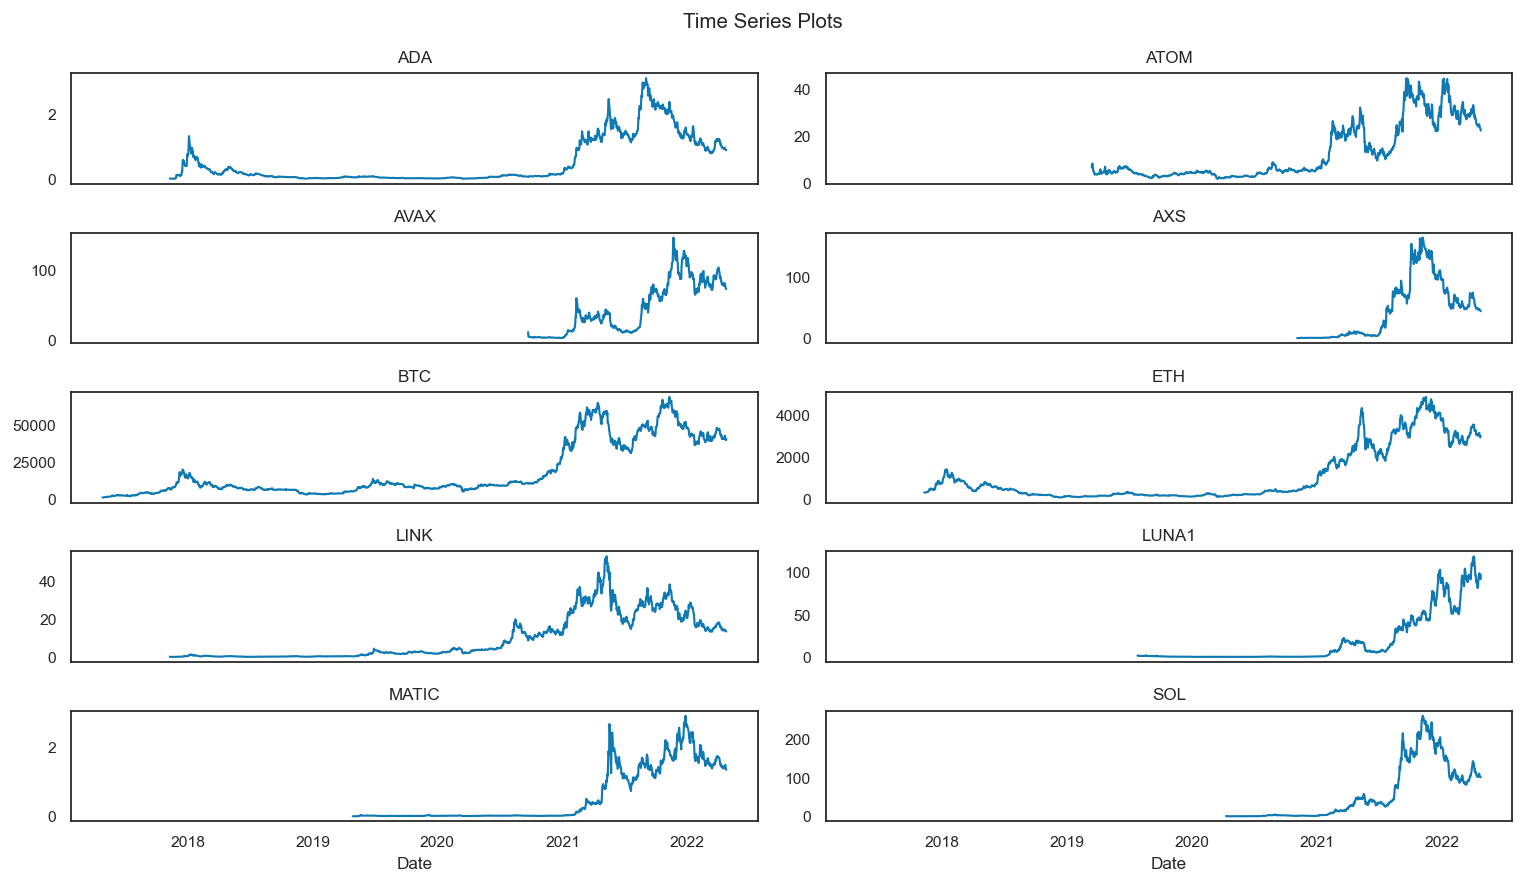

In [27]:
fig, axes = plt.subplots(5,2,figsize=(12,7), sharex=True)

for df_i in range(len(df_coins_list)):
    df_ts = df_coins_list[df_i].copy()
    df_ts['Date'] = pd.to_datetime(df_coins_list[0]['Date']).dt.date
    df_ts.set_index('Date', inplace=True)

    hi = df_coins_suff[df_i]+'_high'
    ci = len(CAT_COLORS)%(df_i+1)
    ax = axes.flatten()[df_i]
    df_ts.loc[:,[hi]].plot(ax=ax, color=CAT_COLORS[1], legend=False)

    ax.set_title(str.upper(df_coins_suff[df_i]))
    #ax.legend([])
    
fig.suptitle("Time Series Plots")
plt.tight_layout()
plt.show()

save_fig("Time Series Plots", fig)


In [28]:
#df_merged

## Get external data

In [29]:
def rename_cols(df, prefix):
    new_names = {
        'Open':prefix+'_open',
        'High':prefix+'_high',
        'Low':prefix+'_low',
        'Close':prefix+'_close',
        'Adj Close':prefix+'_adj_close',
        'Volume':prefix+'_volume',
    }
    return df.rename(columns=new_names)



In [30]:
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

START_DATE = df_merged['Date'].min().strftime('%Y-%m-%d')
END_DATE_ = (df_merged['Date'].max() + timedelta(days=1)).strftime('%Y-%m-%d') 
END_DATE = df_merged['Date'].max().strftime('%Y-%m-%d') 

print(START_DATE, END_DATE, END_DATE_)

2017-04-26 2022-04-25 2022-04-26


In [31]:
#data = pdr.get_data_yahoo("NIM", start=START_DATE, end=END_DATE)

In [32]:
## Gold prices as proxy for risk-aversion
gold_symbol = "GC=F"
gold_data = pdr.get_data_yahoo(gold_symbol, start=START_DATE, end=END_DATE_)
gold_data = gold_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [33]:
gold_data['Date'] = pd.to_datetime(gold_data['Date'])#.dt.date
gold_data.drop(columns=['Adj Close'], inplace=True)
gold_data = rename_cols(gold_data, 'gold')

In [34]:
## SP500 prices 
spy_symbol = "SPY"
spy_data = pdr.get_data_yahoo(spy_symbol, start=START_DATE, end=END_DATE_)
spy_data = spy_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [35]:
spy_data['Date'] = pd.to_datetime(spy_data['Date'])#.dt.date
spy_data.drop(columns=['Adj Close'], inplace=True)
spy_data = rename_cols(spy_data, 'spy')


In [36]:
## VIX prices 
vix_symbol = "^VIX"
vix_data = pdr.get_data_yahoo(vix_symbol, start=START_DATE, end=END_DATE_)
vix_data = vix_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [37]:
vix_data['Date'] = pd.to_datetime(vix_data['Date'])#.dt.date
vix_data.drop(columns=['Adj Close', 'Volume'], inplace=True)
vix_data = rename_cols(vix_data, 'vix')


In [38]:
exog_ = pd.DataFrame(pd.period_range(START_DATE, END_DATE,freq='D'), columns=['Date'])
exog_['Date2'] = pd.to_datetime((exog_['Date']).astype("str"))
exog_.set_index('Date', inplace=True)


exog_merged = exog_.merge(gold_data, left_on='Date2', right_on='Date', how='left')
exog_merged = exog_merged.merge(spy_data, left_on='Date2', right_on='Date', how='left').drop(columns=['Date_x'])
exog_merged = exog_merged.merge(vix_data, left_on='Date2', right_on='Date', how='left').drop(columns=['Date_y'])

exog_merged = exog_merged.drop(columns=['Date']).rename(columns={'Date2':'Date'})
exog_merged.fillna(method='ffill', inplace=True)
exog_merged


,Date,gold_open,gold_high,gold_low,gold_close,gold_volume,spy_open,spy_high,spy_low,spy_close,spy_volume,vix_open,vix_high,vix_low,vix_close
0,2017-04-26,1266.000000,1266.000000,1262.099976,1262.099976,1156.0,238.509995,239.529999,238.350006,238.399994,84702500.0,10.610000,10.890000,10.390000,10.850000
1,2017-04-27,1266.699951,1267.199951,1262.199951,1263.699951,206.0,238.770004,238.949997,237.979996,238.600006,57410300.0,10.720000,11.080000,10.330000,10.360000
2,2017-04-28,1265.900024,1267.199951,1264.699951,1266.099976,85.0,238.899994,238.929993,237.929993,238.080002,63532800.0,10.390000,11.160000,10.290000,10.820000
3,2017-04-29,1265.900024,1267.199951,1264.699951,1266.099976,85.0,238.899994,238.929993,237.929993,238.080002,63532800.0,10.390000,11.160000,10.290000,10.820000
4,2017-04-30,1265.900024,1267.199951,1264.699951,1266.099976,85.0,238.899994,238.929993,237.929993,238.080002,63532800.0,10.390000,11.160000,10.290000,10.820000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2022-04-21,1942.500000,1944.900024,1942.500000,1944.900024,4.0,448.540009,450.010010,437.100006,438.059998,85417300.0,20.240000,23.280001,19.809999,22.680000
1822,2022-04-22,1949.599976,1950.400024,1930.199951,1931.000000,178.0,436.910004,438.079987,425.440002,426.040009,132471800.0,22.709999,28.270000,22.620001,28.209999
1823,2022-04-23,1949.599976,1950.400024,1930.199951,1931.000000,178.0,436.910004,438.079987,425.440002,426.040009,132471800.0,22.709999,28.270000,22.620001,28.209999
1824,2022-04-24,1949.599976,1950.400024,1930.199951,1931.000000,178.0,436.910004,438.079987,425.440002,426.040009,132471800.0,22.709999,28.270000,22.620001,28.209999


In [39]:
df_merged = df_merged.merge(exog_merged, left_on='Date', right_on='Date')

In [40]:
df_merged

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume,atom_close,atom_high,atom_low,atom_open,...,gold_volume,spy_open,spy_high,spy_low,spy_close,spy_volume,vix_open,vix_high,vix_low,vix_close
0,2017-04-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1156.0,238.509995,239.529999,238.350006,238.399994,84702500.0,10.610000,10.890000,10.390000,10.850000
1,2017-04-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,206.0,238.770004,238.949997,237.979996,238.600006,57410300.0,10.720000,11.080000,10.330000,10.360000
2,2017-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,85.0,238.899994,238.929993,237.929993,238.080002,63532800.0,10.390000,11.160000,10.290000,10.820000
3,2017-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,85.0,238.899994,238.929993,237.929993,238.080002,63532800.0,10.390000,11.160000,10.290000,10.820000
4,2017-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,85.0,238.899994,238.929993,237.929993,238.080002,63532800.0,10.390000,11.160000,10.290000,10.820000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2022-04-21,0.910474,0.969453,0.896912,0.937272,8.711113e+08,23.305845,24.913876,23.070230,24.290905,...,4.0,448.540009,450.010010,437.100006,438.059998,85417300.0,20.240000,23.280001,19.809999,22.680000
1822,2022-04-22,0.907154,0.923741,0.893973,0.910335,7.257889e+08,23.089931,23.845695,22.957436,23.305815,...,178.0,436.910004,438.079987,425.440002,426.040009,132471800.0,22.709999,28.270000,22.620001,28.209999
1823,2022-04-23,0.888503,0.910614,0.884660,0.907185,4.479977e+08,23.271534,23.452826,22.864717,23.089521,...,178.0,436.910004,438.079987,425.440002,426.040009,132471800.0,22.709999,28.270000,22.620001,28.209999
1824,2022-04-24,0.886350,0.897855,0.881857,0.888279,4.876295e+08,22.330360,23.259838,22.315559,23.259838,...,178.0,436.910004,438.079987,425.440002,426.040009,132471800.0,22.709999,28.270000,22.620001,28.209999


## Get Technical Analysis

In [41]:
ta_inputs = ["open", "high", "low", "close", "volume"]
ta_cols = ['volume_obv','momentum_rsi','trend_macd','volatility_atr']

In [42]:
rename_ = {}

for i in range(len(ta_cols)):
    rename_[ta_cols[i]] = '_' + ta_cols[i]
rename_

{'volume_obv': '_volume_obv',
 'momentum_rsi': '_momentum_rsi',
 'trend_macd': '_trend_macd',
 'volatility_atr': '_volatility_atr'}

In [43]:
df_ada_ = ta.add_all_ta_features(
    df_ada, "open", "high", "low", "close", "volume", fillna=True
)

In [44]:
#df_ta_ada=
df_ada.loc[:,['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']]

,Date,volume_obv,momentum_rsi,trend_macd,volatility_atr
0,2017-04-26,0.000000e+00,100.000000,0.000000,0.0
1,2017-04-27,0.000000e+00,100.000000,0.000000,0.0
2,2017-04-28,0.000000e+00,100.000000,0.000000,0.0
3,2017-04-29,0.000000e+00,100.000000,0.000000,0.0
4,2017-04-30,0.000000e+00,100.000000,0.000000,0.0
...,...,...,...,...,...
1821,2022-04-21,1.604159e+11,39.973309,-0.031450,0.0
1822,2022-04-22,1.596901e+11,39.653871,-0.033402,0.0
1823,2022-04-23,1.592421e+11,37.825149,-0.036039,0.0
1824,2022-04-24,1.587545e+11,37.609526,-0.037866,0.0


In [45]:
ta_inputs_ = ["ada_open", "ada_high", "ada_low", "ada_close", "ada_volume"]


In [46]:
df_coins_list[0]

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume
0,2017-04-26,NaN,NaN,NaN,NaN,NaN
1,2017-04-27,NaN,NaN,NaN,NaN,NaN
2,2017-04-28,NaN,NaN,NaN,NaN,NaN
3,2017-04-29,NaN,NaN,NaN,NaN,NaN
4,2017-04-30,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1821,2022-04-21,0.910474,0.969453,0.896912,0.937272,8.711113e+08
1822,2022-04-22,0.907154,0.923741,0.893973,0.910335,7.257889e+08
1823,2022-04-23,0.888503,0.910614,0.884660,0.907185,4.479977e+08
1824,2022-04-24,0.886350,0.897855,0.881857,0.888279,4.876295e+08


In [47]:
def plot_bollinger_bands(df, prefix):
    plt.plot(df[[prefix+'_close']])
    plt.plot(df[['volatility_bbh']], label='High BB')
    plt.plot(df[['volatility_bbl']], label='Low BB')
    plt.plot(df[['volatility_bbm']], label='EMA BB')
    plt.title(str.upper(prefix) + ' Bollinger Bands')

In [48]:
########################### Plot all the things later

In [49]:
for dfi in range(len(df_coins_list)):
    df_ = df_coins_list[dfi].dropna()
    df_pref_i = df_coins_suff[dfi]
    ta_cols_rename = {}
    for i in range(len(ta_cols)):
        ta_cols_rename[ta_cols[i]] = df_pref_i + '_' + ta_cols[i]

    df_ta_ = ta.add_all_ta_features(
                    df_, 
                    df_pref_i+"_open", 
                    df_pref_i+"_high", 
                    df_pref_i+"_low", 
                    df_pref_i+"_close", 
                    df_pref_i+"_volume", 
                    fillna=True)

    # plot_bollinger_bands(df_ta_, df_pref_i)
    df_ta_ = df_ta_.loc[:,['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']]    
    df_ta_.rename(columns=ta_cols_rename, inplace=True)
    df_ta_['Date'] = pd.to_datetime(df_ta_['Date'])
    df_merged = df_merged.merge(df_ta_, left_on='Date', right_on='Date') 

In [50]:
df_coins_suff

['ada', 'atom', 'avax', 'axs', 'btc', 'eth', 'link', 'luna1', 'matic', 'sol']

In [51]:
dfi = 1
df_ = df_coins_list[dfi].fillna(0)
df_pref_i = df_coins_suff[dfi]
ta_cols_rename = {}
for i in range(len(ta_cols)):
    ta_cols_rename[ta_cols[i]] = df_pref_i + '_' + ta_cols[i]

df_ta_ = ta.add_all_ta_features(
                df_, 
                df_pref_i+"_open", 
                df_pref_i+"_high", 
                df_pref_i+"_low", 
                df_pref_i+"_close", 
                df_pref_i+"_volume", 
                fillna=True)

# plot_bollinger_bands(df_ta_, df_pref_i)
df_ta_ = df_ta_.loc[:,['Date','volume_obv','momentum_rsi','trend_macd','volatility_atr']]    
df_ta_.rename(columns=ta_cols_rename, inplace=True)
df_ta_['Date'] = pd.to_datetime(df_ta_['Date'])
#df_merged = df_merged.merge(df_ta_, left_on='Date', right_on='Date') 
df_ta_.tail(20)

,Date,atom_volume_obv,atom_momentum_rsi,atom_trend_macd,atom_volatility_atr
1806,2022-04-06,2.907715e+10,41.678795,0.249561,2.057277
1807,2022-04-07,2.962166e+10,44.966536,0.092817,1.980824
1808,2022-04-08,2.893362e+10,42.321576,-0.098783,1.996079
1809,2022-04-09,2.929225e+10,44.020047,-0.215327,1.862104
1810,2022-04-10,2.900832e+10,41.776282,-0.359131,1.762695
1811,2022-04-11,2.834475e+10,34.143869,-0.691472,1.896321
1812,2022-04-12,2.889473e+10,37.891085,-0.875356,1.866613
1813,2022-04-13,2.929396e+10,38.144463,-1.004862,1.768855
1814,2022-04-14,2.875861e+10,36.126530,-1.153194,1.717792
1815,2022-04-15,2.911375e+10,36.799633,-1.245365,1.595769


## Export data

In [52]:
df_merged = df_merged.loc[df_merged['Date']>='01-01-2021',:].reset_index(drop=True)

In [53]:
DATA_OUT_PATH

'../../data_out/'

In [54]:
df_merged.to_csv(DATA_OUT_PATH+"merged_data.csv", index=False)